# Final Classification Model

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from info_gain import info_gain
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Combining Features and Target

In [4]:
macro = pd.read_csv('../data/macro/macro.csv').iloc[1:].reset_index().iloc[:,1:-1]
macro

,date,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS
0,2006-02-28,15278.919000,199.400,4.8,135737.0,177887.0,8.387451e+06,12.34
1,2006-03-31,15290.812000,199.700,4.7,136047.0,178100.0,8.403747e+06,11.39
2,2006-04-30,15302.705000,200.700,4.7,136205.0,178088.0,8.420042e+06,11.59
3,2006-05-31,15310.592667,201.300,4.6,136244.0,177200.0,8.449019e+06,16.44
4,2006-06-30,15318.480333,201.800,4.6,136325.0,177343.0,8.477997e+06,13.08
...,...,...,...,...,...,...,...,...
176,2020-10-31,18794.426000,260.462,6.9,142545.0,212005.0,2.774780e+07,38.02
177,2020-11-30,18794.426000,260.927,6.7,142809.0,208966.0,2.774780e+07,20.57
178,2020-12-31,18794.426000,261.560,6.7,142503.0,205818.0,2.774780e+07,22.75
179,2021-01-31,18794.426000,262.231,6.3,142736.0,221008.0,2.774780e+07,33.09


In [5]:
target = pd.read_csv('../data/target/target.csv')
target

,target
0,1
1,1
2,-1
3,1
4,0
...,...
176,0
177,0
178,0
179,-1


In [6]:
lda = pd.read_csv('../data/text_features/lda.csv')
lda

,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6
0,2.532629e-07,0.442418,0.098614,0.148826,0.021148,2.889927e-01
1,5.791823e-07,0.013136,0.000042,0.970716,0.002117,1.398868e-02
2,2.570856e-07,0.388304,0.011189,0.465910,0.011551,1.230458e-01
3,2.403132e-07,0.492659,0.050694,0.115820,0.125781,2.150454e-01
4,1.027025e-06,0.005665,0.000001,0.992321,0.000148,1.864488e-03
...,...,...,...,...,...,...
176,8.155466e-07,0.001263,0.277596,0.718868,0.000778,1.493741e-03
177,7.587675e-07,0.001052,0.233172,0.763330,0.000944,1.501466e-03
178,8.281763e-07,0.000082,0.501833,0.497920,0.000163,8.281763e-07
179,1.981140e-06,0.000002,0.000002,0.999990,0.000002,1.981140e-06


In [7]:
sentiments = pd.read_csv('../data/text_features/sentiments.csv')
sentiments

,sentiments
0,-0.1
1,0.0
2,0.0
3,0.0
4,0.6
...,...
176,0.1
177,0.1
178,0.1
179,0.3


In [8]:
final_df = pd.concat([macro, lda, sentiments, target], axis=1).iloc[:,1:]
final_df

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments,target
0,15278.919000,199.400,4.8,135737.0,177887.0,8.387451e+06,12.34,2.532629e-07,0.442418,0.098614,0.148826,0.021148,2.889927e-01,-0.1,1
1,15290.812000,199.700,4.7,136047.0,178100.0,8.403747e+06,11.39,5.791823e-07,0.013136,0.000042,0.970716,0.002117,1.398868e-02,0.0,1
2,15302.705000,200.700,4.7,136205.0,178088.0,8.420042e+06,11.59,2.570856e-07,0.388304,0.011189,0.465910,0.011551,1.230458e-01,0.0,-1
3,15310.592667,201.300,4.6,136244.0,177200.0,8.449019e+06,16.44,2.403132e-07,0.492659,0.050694,0.115820,0.125781,2.150454e-01,0.0,1
4,15318.480333,201.800,4.6,136325.0,177343.0,8.477997e+06,13.08,1.027025e-06,0.005665,0.000001,0.992321,0.000148,1.864488e-03,0.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,18794.426000,260.462,6.9,142545.0,212005.0,2.774780e+07,38.02,8.155466e-07,0.001263,0.277596,0.718868,0.000778,1.493741e-03,0.1,0
177,18794.426000,260.927,6.7,142809.0,208966.0,2.774780e+07,20.57,7.587675e-07,0.001052,0.233172,0.763330,0.000944,1.501466e-03,0.1,0
178,18794.426000,261.560,6.7,142503.0,205818.0,2.774780e+07,22.75,8.281763e-07,0.000082,0.501833,0.497920,0.000163,8.281763e-07,0.1,0
179,18794.426000,262.231,6.3,142736.0,221008.0,2.774780e+07,33.09,1.981140e-06,0.000002,0.000002,0.999990,0.000002,1.981140e-06,0.3,-1


In [9]:
final_df.to_csv('../data/combined/combined.csv',index=False)

### Normalising Features

In [10]:
train_size = int(len(final_df) * 0.7)
train, test = final_df[0:train_size], final_df[train_size:len(final_df)]
print('Observations: %d' % (len(final_df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 181
Training Observations: 126
Testing Observations: 55


In [11]:
X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train.target
y_test = test.target

In [12]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std

In [13]:
X_train_norm.describe()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments
count,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02
mean,2.361427e-15,7.419109e-16,-2.185201e-15,2.918301e-15,9.357594e-16,-8.811294e-17,1.182476e-15,1.409807e-17,-2.273314e-16,-1.257812e-16,-3.876969e-17,-2.564087e-16,-2.308559e-16,-1.762259e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.286348e+00,-1.948426e+00,-1.313045e+00,-1.613832e+00,-2.107143e+00,-1.557057e+00,-1.117388e+00,-4.598352e-01,-5.517964e-01,-8.375222e-01,-8.492882e-01,-3.215702e-01,-6.576107e-01,-2.499406e+00
25%,-7.806636e-01,-8.031639e-01,-9.946797e-01,-8.833009e-01,-5.734172e-01,-9.691677e-01,-6.905826e-01,-4.139597e-01,-5.445820e-01,-8.291750e-01,-8.318972e-01,-3.215327e-01,-6.491820e-01,-6.894912e-01
50%,-4.090866e-01,1.264102e-01,-9.264587e-02,8.956371e-02,1.964664e-01,9.675111e-02,-2.928652e-01,-3.608710e-01,-5.057229e-01,-5.583229e-01,-6.180862e-01,-2.981342e-01,-5.906540e-01,-8.618640e-02
75%,6.408306e-01,9.642093e-01,9.553052e-01,5.507161e-01,4.792275e-01,9.190057e-01,3.638440e-01,1.379887e-01,-1.893318e-01,8.482341e-01,1.354534e+00,-1.797519e-01,2.729914e-01,5.171184e-01
max,2.070822e+00,1.432838e+00,1.658361e+00,2.124056e+00,1.684213e+00,1.510761e+00,4.417093e+00,6.999801e+00,3.094864e+00,1.821035e+00,1.459208e+00,6.595048e+00,3.751794e+00,3.533643e+00


### Feature Selection

#### Variance Inflation Factor

In [14]:
def cal_vif(x):
    thresh = 5
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1, k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif ', a)
        if vif[a] <= thresh:
            break
        if i == 1:
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output

x = pd.DataFrame(X_train)
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[89.46620057068877, 31.989285230637716, 96.71688559242031, 95.89055616450821, 38.189623165413046, 1054.0611227662132, 2.8885708147937708, 2.01223819056945, 8426.188128862283, 21892.09662075325, 29661.087840955373, 657.9946680621017, 6550.3694949098635, 1.1336035346047724]
Max vif  10
Iteration no  2
[34666.44275175478, 10686.697663214558, 110.28632380956346, 29427.00725000255, 8532.875609510214, 950.4682364242468, 18.01055880616826, 1.9549884048121808, 2.6124777710204654, 3.5874959876784995, 1.2631961266646154, 2.090518904957005, 1.1064158854191493]
Max vif  0
Iteration no  3
[10563.676793496443, 98.21234548609091, 10848.84455213932, 7397.323421126925, 334.8695451489139, 17.920222059588962, 1.947298376953266, 2.608366332200117, 3.5403655718637137, 1.2436446809851207, 2.069920270638164, 1.1055394502598077]
Max vif  2
Iteration no  4
[7156.236045930826, 96.30207421542161, 4096.595468105844, 174.55988042736345, 13.628924062457454, 1.9073993478920515, 2.483760089718517, 3.5

,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_5,prob_topic_6,sentiments
0,12.34,2.532629e-07,0.442418,0.098614,0.021148,0.288993,-0.1
1,11.39,5.791823e-07,0.013136,0.000042,0.002117,0.013989,0.0
2,11.59,2.570856e-07,0.388304,0.011189,0.011551,0.123046,0.0
3,16.44,2.403132e-07,0.492659,0.050694,0.125781,0.215045,0.0
4,13.08,1.027025e-06,0.005665,0.000001,0.000148,0.001864,0.6


#### Random Forest Feature Importance

In [15]:
rf_clf = RandomForestClassifier(random_state=1).fit(X_train, y_train)

In [16]:
rf_clf.feature_importances_

array([0.08603286, 0.09145494, 0.05096791, 0.06963577, 0.10484947,
       0.10061667, 0.0782531 , 0.02054782, 0.07631474, 0.05892946,
       0.06690377, 0.06766941, 0.07488357, 0.05294051])

In [17]:
importance = rf_clf.feature_importances_

Feature: 0, Score: 0.08603
Feature: 1, Score: 0.09145
Feature: 2, Score: 0.05097
Feature: 3, Score: 0.06964
Feature: 4, Score: 0.10485
Feature: 5, Score: 0.10062
Feature: 6, Score: 0.07825
Feature: 7, Score: 0.02055
Feature: 8, Score: 0.07631
Feature: 9, Score: 0.05893
Feature: 10, Score: 0.06690
Feature: 11, Score: 0.06767
Feature: 12, Score: 0.07488
Feature: 13, Score: 0.05294


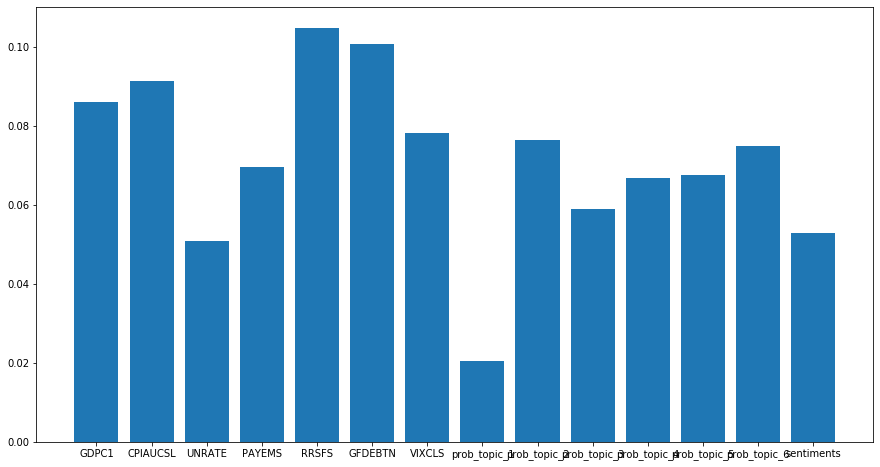

In [18]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(15,8))
plt.bar([final_df.columns[x] for x in range(len(importance))], importance)
plt.show()

#### Information Gain Ratio

In [19]:
cols = final_df.iloc[:, :-1].columns
igr_list = []
for col in cols:
    key_value = [col]
    igr = info_gain.info_gain_ratio(
        final_df['target'].values.tolist(), 
        final_df[col].values.tolist())
    key_value.append(igr)
    igr_list.append(key_value)
igr_list = sorted(igr_list, key=lambda x: x[1], reverse=True)

In [20]:
igr_list

[['RRSFS', 0.14576104445178575],
 ['prob_topic_1', 0.14576104445178575],
 ['prob_topic_2', 0.14576104445178575],
 ['prob_topic_3', 0.14576104445178575],
 ['prob_topic_4', 0.14576104445178575],
 ['prob_topic_5', 0.14576104445178575],
 ['prob_topic_6', 0.14576104445178575],
 ['CPIAUCSL', 0.1453823994969227],
 ['GDPC1', 0.1451593642523349],
 ['GFDEBTN', 0.1451593642523349],
 ['PAYEMS', 0.14495337584117837],
 ['VIXCLS', 0.1445705786689036],
 ['UNRATE', 0.07548727288883196],
 ['sentiments', 0.037195671118259055]]

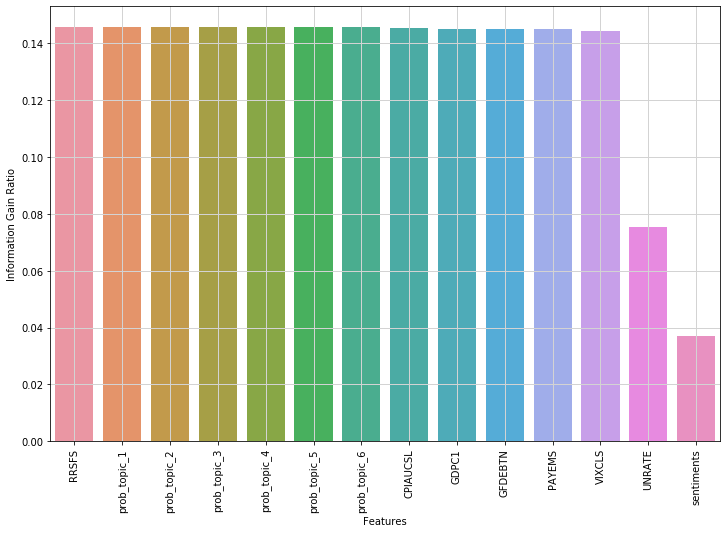

In [21]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Features", 
                 y="Information Gain Ratio", 
                 data=pd.DataFrame(igr_list, 
                                   columns=['Features', 
                                            'Information Gain Ratio']))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

##### Final Feature Set 1 (Unique Top 3 Features from Each Method)

In [22]:
igr_top_3 = [x[0] for x in igr_list][:3]

In [23]:
vif_top_3 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][:3]

In [24]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_3 = [final_df.columns[x] for x in indices][:3]

In [25]:
final_set = []
for i in igr_top_3:
    if i not in final_set:
        final_set.append(i)
for j in vif_top_3:
    if j not in final_set:
        final_set.append(j)
for k in rf_top_3:
    if k not in final_set:
        final_set.append(k)
final_set

['RRSFS', 'prob_topic_1', 'prob_topic_2', 'VIXCLS', 'GFDEBTN', 'CPIAUCSL']

##### Final Feature Set 2 (Unique Top 1 Feature from Each Method)

In [26]:
igr_top_1 = [x[0] for x in igr_list][0]

In [27]:
vif_top_1 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][0]

In [28]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_1 = [final_df.columns[x] for x in indices][0]

In [29]:
final_set_1=[igr_top_1, vif_top_1, rf_top_1]

In [30]:
final_set_1=list(set(final_set_1))
final_set_1

['RRSFS', 'VIXCLS']

### Preparing Datasets

##### All Features

In [31]:
X_all = final_df.drop(columns=['target'])
y_all = final_df.target

##### Selected Features (Set 1)

In [32]:
if 'target' not in final_set:
    final_set.append('target')
    
df_fs = final_df[final_set]
X_fs1 = df_fs.drop(columns=['target'])
y_fs1 = df_fs.target

##### Selected Features (Set 2)

In [33]:
if 'target' not in final_set_1:
    final_set_1.append('target')
    
df_fs = final_df[final_set_1]
X_fs2 = df_fs.drop(columns=['target'])
y_fs2 = df_fs.target

In [34]:
data = [('All features', X_all, y_all),
        ('Feature set 1', X_fs1, y_fs1),
        ('Feature set 2', X_fs2, y_fs2)]

### Stacking and Cross-Validation

#### Stacking Classifiers

In [35]:
base_learners = [("SVC", SVC(random_state=1)),
                 ("Decision Tree", DecisionTreeClassifier(random_state=1)),
                 ("Logistic Regression", LogisticRegression(random_state=1, max_iter=200))]

##### Log Reg as Meta Learner

In [36]:
clf_lr = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=1, max_iter=200))

##### Decision Tree as Meta Learner

In [37]:
clf_dt = StackingClassifier(estimators=base_learners, final_estimator=DecisionTreeClassifier(random_state=1))

#### TimeSeriesSplit Cross-Validation

In [38]:
classifiers = []
classifiers.extend([("Log Reg as Meta Learner", clf_lr), 
                    ("Decision Tree as Meta Learner", clf_dt)])

In [39]:
results = []
classifier_name = []
dataset = []
for dt in data:
    X = dt[1]
    y = dt[2]
    for clf in classifiers:
        tscv = TimeSeriesSplit(n_splits=5)
        all_y_preds = []
        all_y_true = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
            y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
            clf[1].fit(X_train, y_train)
            y_preds = clf[1].predict(X_test)
            all_y_preds.extend(y_preds)
            all_y_true.extend(y_test)
        dataset.append(dt[0])
        results.append(f1_score(all_y_true,all_y_preds, average='weighted'))
        classifier_name.append(clf[0])

In [40]:
final_results = pd.DataFrame([dataset, classifier_name, results]).transpose()\
                                                    .rename(columns={0:'Dataset',\
                                                                     1:'Model',\
                                                                     2:'F1-Weighted'})\
                                                    .sort_values(by='F1-Weighted', \
                                                                 ascending=False)\
                                                    .reset_index().iloc[:,1:]
final_results

,Dataset,Model,F1-Weighted
0,Feature set 1,Decision Tree as Meta Learner,0.429473
1,All features,Decision Tree as Meta Learner,0.351989
2,All features,Log Reg as Meta Learner,0.304176
3,Feature set 1,Log Reg as Meta Learner,0.302684
4,Feature set 2,Log Reg as Meta Learner,0.288166
5,Feature set 2,Decision Tree as Meta Learner,0.243363


Feature set 1: ['RRSFS', 'prob_topic_1', 'prob_topic_2', 'VIXCLS', 'GFDEBTN', 'CPIAUCSL']